# Regression Challenge

Predicting the selling price of a residential property depends on a number of factors, including the property age, availability of local amenities, and location.

In this challenge, you will use a dataset of real estate sales transactions to predict the price-per-unit of a property based on its features. The price-per-unit in this data is based on a unit measurement of 3.3 square meters.

> **Citation**: The data used in this exercise originates from the following study:
>
> *Yeh, I. C., & Hsu, T. K. (2018). Building real estate valuation models with comparative approach through case-based reasoning. Applied Soft Computing, 65, 260-271.*
>
> It was obtained from the UCI dataset repository (Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science).

## Review the data

Run the following cell to load the data and view the first few rows.

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

In [88]:
# load the training dataset
data = pd.read_csv('data/real_estate.csv')
data.head()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


The data consists of the following variables:

- **transaction_date** - the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
- **house_age** - the house age (in years)
- **transit_distance** - the distance to the nearest light rail station (in meters)
- **local_convenience_stores** - the number of convenience stores within walking distance
- **latitude** - the geographic coordinate, latitude
- **longitude** - the geographic coordinate, longitude
- **price_per_unit** house price of unit area (3.3 square meters)

## Train a Regression Model

Your challenge is to explore and prepare the data, identify predictive features that will help predict the **price_per_unit** label, and train a regression model that achieves the lowest Root Mean Square Error (RMSE) you can achieve (which must be less than **7**) when evaluated against a test subset of data.

Add markdown and code cells as required to create your solution.

> **Note**: There is no single "correct" solution. A sample solution is provided in [02 - Real Estate Regression Solution.ipynb](02%20-%20Real%20Estate%20Regression%20Solution.ipynb).

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_date          414 non-null    float64
 1   house_age                 414 non-null    float64
 2   transit_distance          414 non-null    float64
 3   local_convenience_stores  414 non-null    int64  
 4   latitude                  414 non-null    float64
 5   longitude                 414 non-null    float64
 6   price_per_unit            414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


In [90]:
data.describe()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [91]:
data['Year_transaction'] = data['transaction_date']//1
data['Month_transaction'] =(((data['transaction_date']%1)*360)/30)+1
data['Year_transaction'] = data['Year_transaction'].astype(int)
data['Month_transaction'] = data['Month_transaction'].astype(int)

data = data.drop('transaction_date', 1)

data

,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit,Year_transaction,Month_transaction
0,32.0,84.87882,10,24.98298,121.54024,37.9,2012,12
1,19.5,306.59470,9,24.98034,121.53951,42.2,2012,12
2,13.3,561.98450,5,24.98746,121.54391,47.3,2013,7
3,13.3,561.98450,5,24.98746,121.54391,54.8,2013,7
4,5.0,390.56840,5,24.97937,121.54245,43.1,2012,10
...,...,...,...,...,...,...,...,...
409,13.7,4082.01500,0,24.94155,121.50381,15.4,2013,1
410,5.6,90.45606,9,24.97433,121.54310,50.0,2012,9
411,18.8,390.96960,7,24.97923,121.53986,40.6,2013,4
412,8.1,104.81010,5,24.96674,121.54067,52.5,2013,1


In [92]:
database = data
numeric_features = ['house_age', 'transit_distance', 'local_convenience_stores', 'latitude', 'longitude']
categorical_features = ['Year_transaction','Month_transaction']
all_features = numeric_features+categorical_features
target = database['price_per_unit']
target_text = 'price_per_unit'

## Data Exploration

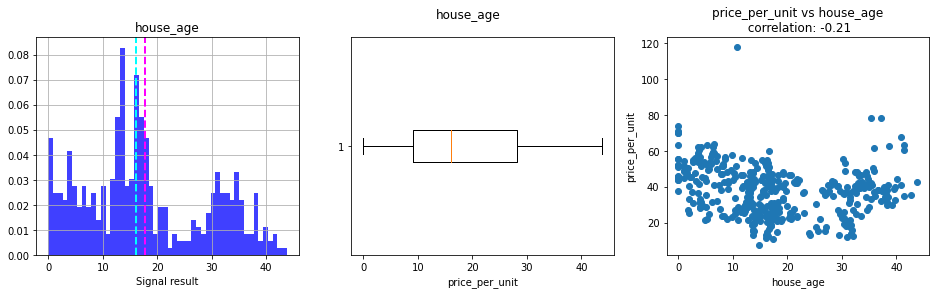

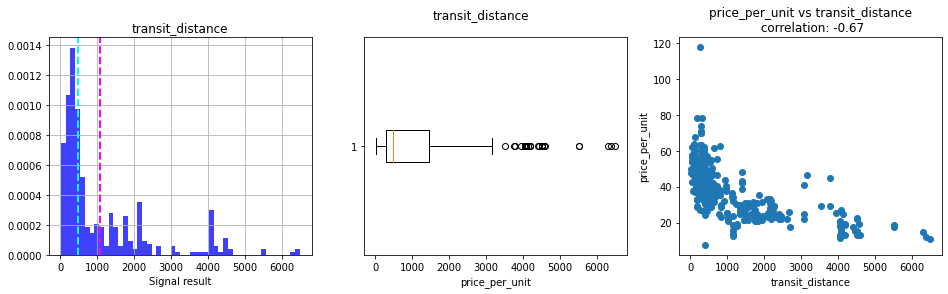

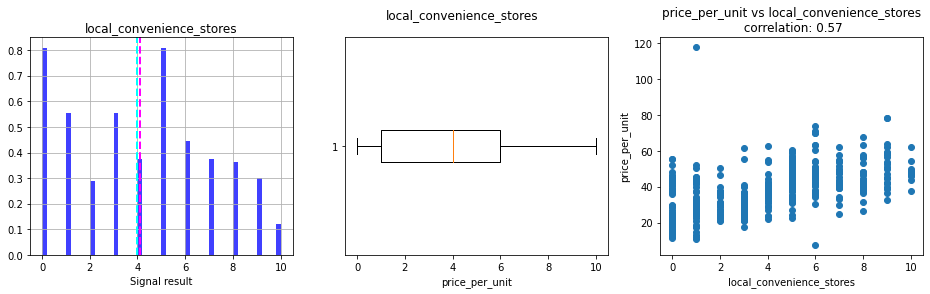

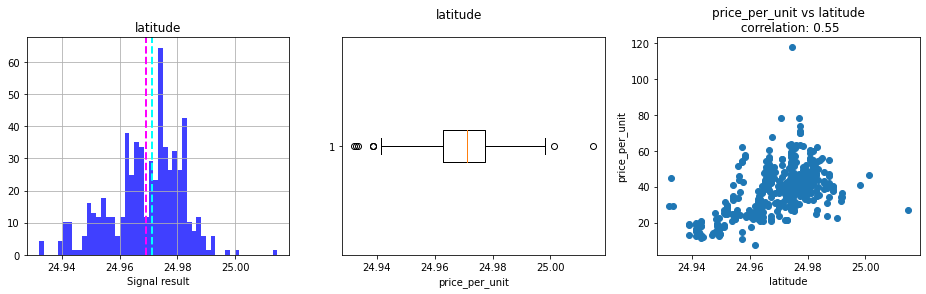

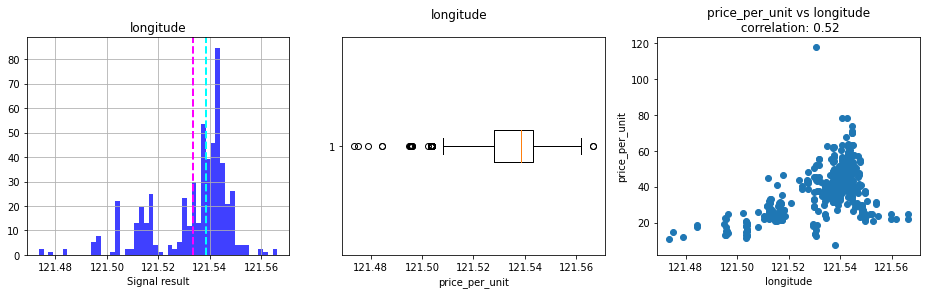

In [93]:

for col in numeric_features:
    
    fig, ax = plt.subplots(1, 3, figsize = (16,4))
    
    w, bins, patches = ax[0].hist(database[col], 50, density=True, facecolor='b', alpha=0.75)
    ax[0].set_xlabel('Signal result')
    ax[0].axvline(database[col].mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax[0].axvline(database[col].median(), color='cyan', linestyle='dashed', linewidth=2)
    ax[0].set_title(col)
    ax[0].grid(True)

    ax[1].boxplot(database[col], vert=False)
    ax[1].set_title('')
    ax[1].set_xlabel(target_text)
    ax[1].set_ylabel('')

    correlation = database[col].corr(target)
    ax[2].scatter(x=database[col], y=target)
    ax[2].set_xlabel(col)
    ax[2].set_ylabel(target_text)
    ax[2].set_title( target_text +' vs ' + col + '\n correlation: ' + str(round(correlation,2)))

    
    fig.suptitle(col)
    fig.show()

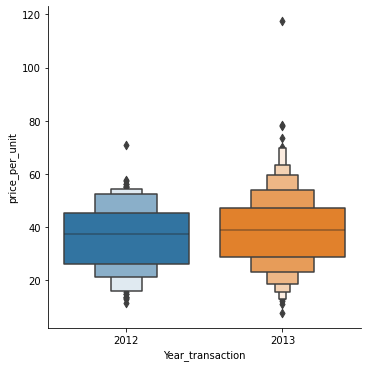

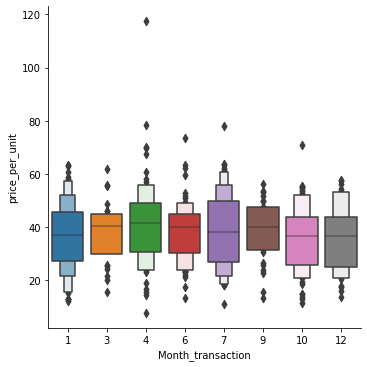

In [94]:
for col in categorical_features:
    sns.catplot(x=col, y=target_text, kind="boxen", data=database.sort_values(col))

## Train a Regression Model

In [95]:
for n in categorical_features:
    dummies = pd.get_dummies(database[n])
    database = pd.concat([database, dummies], axis=1)
    database = database.drop(n, axis=1)

database = database.drop(target_text, axis=1)
database

,house_age,transit_distance,local_convenience_stores,latitude,longitude,2012,2013,1,3,4,6,7,9,10,12
0,32.0,84.87882,10,24.98298,121.54024,1,0,0,0,0,0,0,0,0,1
1,19.5,306.59470,9,24.98034,121.53951,1,0,0,0,0,0,0,0,0,1
2,13.3,561.98450,5,24.98746,121.54391,0,1,0,0,0,0,1,0,0,0
3,13.3,561.98450,5,24.98746,121.54391,0,1,0,0,0,0,1,0,0,0
4,5.0,390.56840,5,24.97937,121.54245,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,13.7,4082.01500,0,24.94155,121.50381,0,1,1,0,0,0,0,0,0,0
410,5.6,90.45606,9,24.97433,121.54310,1,0,0,0,0,0,0,1,0,0
411,18.8,390.96960,7,24.97923,121.53986,0,1,0,0,1,0,0,0,0,0
412,8.1,104.81010,5,24.96674,121.54067,0,1,1,0,0,0,0,0,0,0


In [96]:
x, y = database.values, target.values
print(f'x shape {x.shape}')
print(f'y shape {y.shape}')

x shape (414, 15)
y shape (414,)


In [97]:
# Split data 70%-30% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

print (f'Training Set: {x_train.shape} rows\nTest Set: {x_test.shape}  rows')

Training Set: (289, 15) rows
Test Set: (125, 15)  rows


In [98]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [99]:
model1 = LinearRegression().fit(x_train, (y_train))
model2 = RandomForestRegressor().fit(x_train, (y_train))
model3 = DecisionTreeRegressor().fit(x_train, (y_train))
model4 = Lasso().fit(x_train, (y_train))
model5 = SVR().fit(x_train, (y_train))

In [100]:
regressor = GradientBoostingRegressor()

# Gridsearch
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }

score = make_scorer(r2_score)
gridsearch = GridSearchCV(regressor, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(x_train, y_train)

model6 = gridsearch.best_estimator_.fit(x_train, (y_train))

In [101]:
d = []
models = [model1, model2, model3, model4, model5, model6]

for model in models:
    predictions = model.predict(x_test)
    residuals = y_test - predictions
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    d.append([model,round(mse,2),round(rmse,2),round(r2,2), sum(residuals)])

print(tabulate(d, headers=["Model", "MSE", "RMSE", "R2", "Residuals"]))

Model                                          MSE    RMSE    R2    Residuals
------------------------------------------  ------  ------  ----  -----------
LinearRegression()                           69.86    8.36  0.59   -152.597
RandomForestRegressor()                      56.9     7.54  0.67    -87.225
DecisionTreeRegressor()                     116.95   10.81  0.31   -125.5
Lasso()                                      74.84    8.65  0.56   -167.754
SVR()                                        98.05    9.9   0.42      0.68895
GradientBoostingRegressor(n_estimators=50)   59.64    7.72  0.65   -137.325


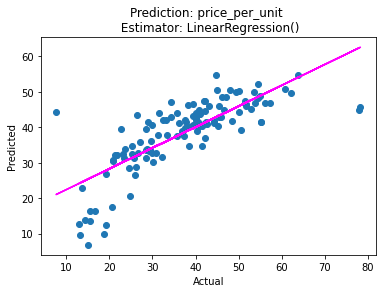

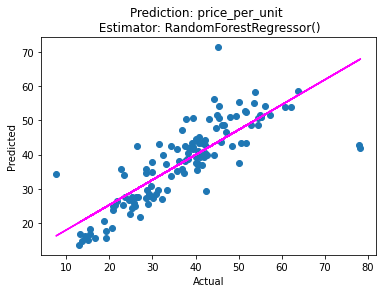

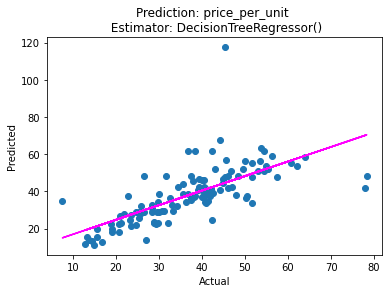

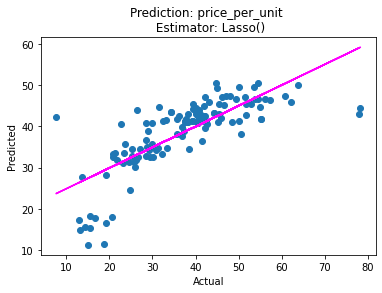

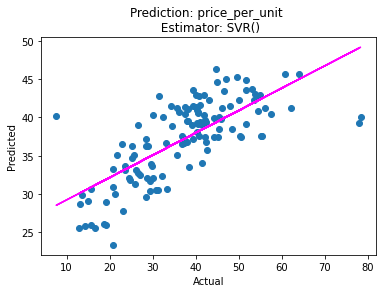

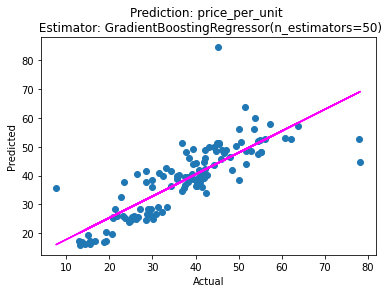

In [102]:
for model in models:
    predictions = model.predict(x_test)
    plt.scatter(y_test, predictions)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Prediction: {target_text} \n Estimator: {model}')
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')
    plt.show()

In [103]:
import joblib

bestmodel = model2

# Save the model as a pickle file
filename = f'./{target_text}.pkl'
joblib.dump(bestmodel, filename)

['./price_per_unit.pkl']

## Use the Trained Model

Save your trained model, and then use it to predict the price-per-unit for the following real estate transactions:

| transaction_date | house_age | transit_distance | local_convenience_stores | latitude | longitude |
| ---------------- | --------- | ---------------- | ------------------------ | -------- | --------- |
|2013.167|16.2|289.3248|5|24.98203|121.54348|
|2013.000|13.6|4082.015|0|24.94155|121.50381|

In [119]:
x_new = np.array([[16.2,289.3248,5,24.98203,121.54348,0,1,0,1,0,0,0,0,0,0],
[13.6,4082.015,0,24.94155,121.50381,0,1,1,0,0,0,0,0,0,0]])

In [122]:
database_new

# Load the model from the file
loaded_model = joblib.load(filename)


# Use the model to predict tomorrow's rentals
results = loaded_model.predict(x_new)
print('Predictions:')
for prediction in results:
    print(round(prediction,2))

Predictions:
32.72
32.6
